<a href="https://colab.research.google.com/github/rosebuddychomp/Cybersecurity/blob/main/packet_sniffer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Libraries**


In [55]:
!pip install pandas dpkt

**mount drive or upload file**

In [56]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
pcap_filepath= "/content/drive/MyDrive/CyberSecurity/Projects/samplecapture01.pcap"

 **What the script do:<br>
  <ul>reads .pcap file using dpkt.pcap.Reader<ul>
  <ul>extracts source IP, destination IP, protocol type and timestamp<ul>
  <ul>stores data in a Pandas DataFrame for analysis<ul>**

In [60]:
def read_pcap(file_path):
    packets = []
    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for timestamp, buf in pcap:
            try:
                eth = dpkt.ethernet.Ethernet(buf)
                if isinstance(eth.data, dpkt.ip.IP):
                    ip = eth.data
                    src_ip = socket.inet_ntoa(ip.src)
                    dst_ip = socket.inet_ntoa(ip.dst)
                    protocol = ip.p
                    packets.append([timestamp, src_ip, dst_ip, protocol])
            except Exception as e:
                print("Error reading packet:", e)  # Debugging info
                continue

    df = pd.DataFrame(packets, columns=['Timestamp', 'Source IP', 'Destination IP', 'Protocol'])
    print("Total Packets Extracted:", len(df))  # Check if any packets were extracted
    return df

df = read_pcap(pcap_filepath)


Total Packets Extracted: 12965


In [61]:
print(df.head)
print(df.shape)

<bound method NDFrame.head of           Timestamp    Source IP  Destination IP  Protocol
0      1.014609e+09  192.168.0.2     192.168.0.1        17
1      1.014609e+09  192.168.0.1     192.168.0.2        17
2      1.014609e+09  192.168.0.2     192.168.0.1        17
3      1.014609e+09  192.168.0.1     192.168.0.2        17
4      1.014609e+09  192.168.0.2  192.168.37.115        17
...             ...          ...             ...       ...
12960  1.014609e+09  192.168.0.2     192.168.0.1        17
12961  1.014609e+09  192.168.0.2     101.168.0.1        17
12962  1.014609e+09  192.168.0.2     192.168.0.1        17
12963  1.014609e+09  192.168.0.2     192.168.0.1        17
12964  1.014609e+09  192.168.0.2     192.168.0.1        17

[12965 rows x 4 columns]>
(12965, 4)


**Visualize Network Traffic**

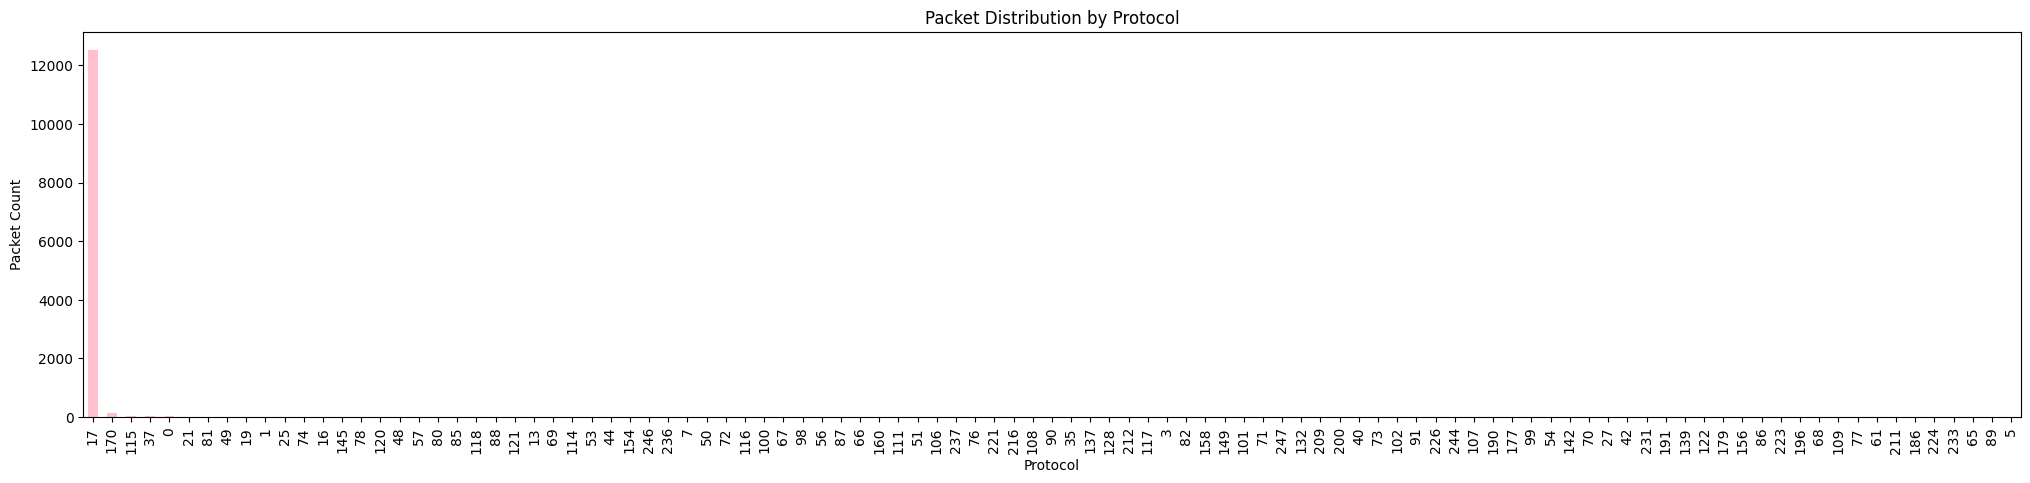

In [65]:
import matplotlib.pyplot as plt

protocol_counts=df['Protocol'].value_counts()

#plot distribution
plt.figure(figsize=(25,5))
protocol_counts.plot(kind='bar',color='pink')
plt.xlabel("Protocol")
plt.ylabel("Packet Count")
plt.title("Packet Distribution by Protocol")
plt.show()

**Most Active IPs**

In [66]:
df['Source IP'].value_counts().head(10)

,count
Source IP,
192.168.0.2,8982
192.168.0.1,2717
170.170.170.170,184
0.168.0.2,26
192.168.0.37,26
37.115.0.2,25
192.168.37.115,22
192.37.115.0,21
115.0.0.2,18


**Packets over Time**

Unique timestamps: 12965
Resampling using interval: 1min


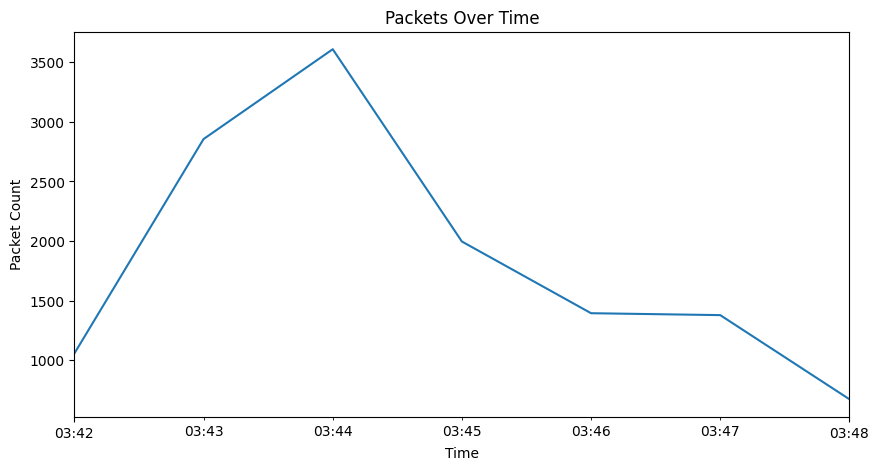

In [67]:
# Ensure proper timestamp format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', errors='coerce')

# Check for NaT values
num_invalid_timestamps = df['Timestamp'].isna().sum()
if num_invalid_timestamps > 0:
    print(f"Warning: {num_invalid_timestamps} invalid timestamps found!")

# Check unique timestamps
num_unique_timestamps = df['Timestamp'].nunique()
print(f"Unique timestamps: {num_unique_timestamps}")

if df.empty or num_unique_timestamps == 0:
    print("No valid packets found. Check your .pcap file!")
elif num_unique_timestamps == 1:
    print("Only one unique timestamp found, try a different time scale.")
    df.set_index('Timestamp').resample('1S').count()['Protocol'].plot()
else:
    # Check timestamp range
    timestamp_range = df['Timestamp'].max() - df['Timestamp'].min()

    # Adjust resampling interval based on time span
    if timestamp_range.total_seconds() <= 60:
        resample_interval = '1s'  # If the data is within a minute, use 1 second
    elif timestamp_range.total_seconds() <= 3600:
        resample_interval = '1min'  # If within an hour, use 1 minute
    else:
        resample_interval = '10min'  # For larger time spans, use 10 minutes

    print(f"Resampling using interval: {resample_interval}")

    # Plot packets over time
    plt.figure(figsize=(10, 5))
    df.set_index('Timestamp').resample(resample_interval).count()['Protocol'].plot()
    plt.xlabel("Time")
    plt.ylabel("Packet Count")
    plt.title("Packets Over Time")
    plt.show()
